# ENSO Phase Prediction

The El Niño Southern Oscillation (ENSO) is a climate phenomenon that occurs in the Pacific ocean. It is characterized by a periodic warming and cooling of the sea surface temperature. The ENSO phase can be classified into three categories: El Niño, La Niña, and Neutral. This event has a significant impact on weather patterns around the world, and is of great interest to climate scientists.

### Sea Surface Temperature Data: NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5

The NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5 dataset is a global monthly sea surface temperature dataset. It is a blend of in situ and satellite data that begins in 1854 and is updated monthly. The data is available in netCDF format from the NOAA website.

A subset of the data has already been prepared for this workshop. In particular, we will focus our attention on a region in the Pacific ocean (40S-40N, 120E-100W) from 1854-2023. More specifically, we will use the sea surface temperature anomaly (SSTA) data, which is the difference between the sea surface temperature and the long-term average. This data is stored in a 3D array (time, lat, lon) in netCDF format, which is a common format for climate data.

NetCDF is a common data format for climate data. It is a self-describing format that is optimized for storing large arrays. It is supported by most programming languages and has a number of useful tools for working with the data. See the NetCDF website for more information.

<a href="https://colab.research.google.com/github/peterjsadowski/tutorial_climate_ai/blob/main/02_predict_ENSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

To start, import all the relevant libraries. If these libraries are not installed, run `!pip install torch xarray urllib matplotlib` from a new cell.

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import urllib
import torch
import torch.nn as nn
import xarray as xr
from torch.utils.data import DataLoader

First we select a device to train the model on. If you are using Google Colab, you can use a GPU by selecting Runtime -> Change runtime type -> Hardware accelerator -> GPU. If you are using your own computer, you can use a GPU if you have one available. Otherwise, you can use the CPU.

In [24]:
torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device(type='cpu')

## Download and Preprocess Data

Download the data to the local environment



In [25]:
# Create data dir.
directory_path = "data"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")

# Download data files from github repo
def download(url):
    filename = os.path.join(directory_path, url.split('/')[-1])
    if os.path.exists(filename):
        print(f'File {filename} already exists.')
    else:
        # Try to download
        try:
            urllib.request.urlretrieve(url, filename)
            print(f'File {filename} downloaded.')
        except Exception as e:
            print(f'Error downloading file {filename}: {e}')


urls = ['https://github.com/peterjsadowski/tutorial_climate_ai/data/ersst_pacific_anom.nc',
        'https://github.com/peterjsadowski/tutorial_climate_ai/data/labels.csv',
        'https://github.com/peterjsadowski/tutorial_climate_ai/data/ersst_anom_dec2023.nc'
]
for url in urls:
    download(url)



Directory 'data' already exists.
File data/ersst_pacific_anom.nc already exists.
File data/labels.csv already exists.
File data/ersst_anom_dec2023.nc already exists.


Load the data into an xarray dataset using the xr.open_dataset function and select the variable ssta (sea surface temperature anomaly). The data is a 3D array (time, lat, lon) with missing values. We will fill in the missing values with zeros.

In [26]:
netcdf_file = xr.open_dataset("data/ersst_pacific_anom.nc")
ssta = (
    netcdf_file.ssta.expand_dims("channel")
    .transpose("time", "channel", "lat", "lon")
    .fillna(0)
)

We will now load the labels for the ENSO phase which has been prepared for this workshop and can be downloaded from this link. The labels are stored in a pandas dataframe with 4 columns: date, lead_1, lead_2, lead_3. The date column is the date of the observation, while the lead columns are the ENSO phase 1, 2, and 3 months in the future. The ENSO phase has been converted to a categorical variable with 3 classes: 0 (Neutral), 1 (El Niño), and 2 (La Niña).



In [27]:
labels_df = pd.read_csv("data/labels.csv")
one_hot_labels = nn.functional.one_hot(
    torch.from_numpy(labels_df[["lead_1", "lead_2", "lead_3"]].values).long(),
    num_classes=3,
).float()

One hot encoding is a method for converting categorical variables into numerical variables. For example, if we have a variable that can take on the values “red”, “green”, and “blue”, we can convert this into a numerical variable by assigning each category a number: 0, 1, and 2. However, this implies that “red” is closer to “green” than it is to “blue”, which is not true. One hot encoding solves this problem by creating a new variable for each category. In this case, we would have three variables: red, green, and blue. If the original variable was “red”, then the red variable would be 1 and the green and blue variables would be 0. If the original variable was “blue”, then the blue variable would be 1 and the red and green variables would be 0. This is a more appropriate representation of the data.

```
color	Red	Green	Blue
Red	1	0	0
Green	0	1	0
Blue	0	0	1
```

## Define the Training Set

Now that we have the data loaded, we need to prepare it in a format that Pytorch can use. We will define a dataset class that will take in the data and labels and return a single example. We will then use the Pytorch DataLoader class to create a data loader that will feed the data into the model in batches.

In machine learning, it is critical to split the data into **training** and **test sets**. The training set is used to train the model, while the test set is used to evaluate the model. Machine learning models tend to memorize the training data, so the training error always goes to zero — the only way to know if the model **generalizes** to new data is by evaluating the performance on the test set, a method known as **cross-validation**.

In timeseries data, there is a danger of **information leakage** where the training set is highly correlated to the test set (even if the exact examples are different). Thus, it is common use **chrono-cross-validation**, where the training data consists of examples before a certain time T, while the test set consists of examples after time T.

In [28]:
# now we have to create a dataset that can be used by pytorch

class ENSODataset(torch.utils.data.Dataset):
    def __init__(self, ssta, labels):
        self.ssta = ssta
        self.labels = labels

    def __len__(self):
        return len(self.ssta)

    def __getitem__(self, idx):
        return self.ssta[idx], self.labels[idx]


# we will use the first 80% of the data for training and the last 20% for testing
train_size = int(0.8 * len(ssta))

train_dataset = ENSODataset(ssta[:train_size].data.copy(), one_hot_labels[:train_size])
test_dataset = ENSODataset(ssta[train_size:].data.copy(), one_hot_labels[train_size:])

We will use a batch size of 32 and shuffle the training data.


In [29]:
# Build the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

## Defining the Model

Similar to the MNIST example, we will use a convolutional neural network (CNN) model as we are working with image data. As we want to predict the next 3 months of ENSO phase, we will have 3 output nodes (one for each lead time) each with 3 possible values (one for each ENSO phase). We will use the cross entropy loss function and the Adam optimizer.



In [30]:
class ENSOModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 8 * 20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        x_lead_1 = self.fc3(x)
        x_lead_2 = self.fc3(x)
        x_lead_3 = self.fc3(x)

        return x_lead_1, x_lead_2, x_lead_3

Note on designing a neural network architecture:

The neural network architecture can have a large impact on performance. The inductive bias of a model refers to the set of assumptions and prior beliefs that are inherent in this choice. All machine learning models have inductive bias. This is not a bad thing, but it means some models are more appropriate for some problems than others. This is formalized in what is known as The No Free Lunch Theorem.

Experienced practicioners know which architectures tend to work best for certain types of problems. Bigger models usually work better, but are slower because of computational constraints. In practice, it is common to try lots of different models and perform model selection to pick the best based on how well the model performs on a test set.


## Training the Model

Training the model is an iterative process. Starting from randomly initialized parameters, we iterate through the training examples, make predictions, and update the weight parameters to minimize the **loss function**. In this case, we use the cross entropy loss. We keep track of the average loss over the training set, and report it every time we iterate through the training dataset — each iteration through the training set is called an **epoch**.

We can now write the training loop.


In [31]:
model = ENSOModel()

# define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train the model
epochs = 60
train_loss = []

for epoch in range(epochs):
    epoch_loss = []

    model.train()

    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # forward + backward + optimize
        output_lead_1, output_lead_2, output_lead_3 = model(data)
        loss = (
            loss_fn(output_lead_1, target[:, 0])
            + loss_fn(output_lead_2, target[:, 1])
            + loss_fn(output_lead_3, target[:, 2])
        )

        epoch_loss.append(loss.item() * data.size(0))

        loss.backward()
        optimizer.step()

        # print statistics
        if batch_idx % 400 == 0:
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")
    train_loss.append(sum(epoch_loss) / len(train_dataset))

Epoch: 0, Batch: 0, Loss: 3.436413288116455
Epoch: 1, Batch: 0, Loss: 2.8708901405334473
Epoch: 2, Batch: 0, Loss: 2.4984560012817383
Epoch: 3, Batch: 0, Loss: 2.06510066986084
Epoch: 4, Batch: 0, Loss: 1.659157156944275
Epoch: 5, Batch: 0, Loss: 1.542259931564331
Epoch: 6, Batch: 0, Loss: 1.6178257465362549
Epoch: 7, Batch: 0, Loss: 1.0360450744628906
Epoch: 8, Batch: 0, Loss: 0.7862735390663147
Epoch: 9, Batch: 0, Loss: 0.9208210706710815
Epoch: 10, Batch: 0, Loss: 0.9365091323852539
Epoch: 11, Batch: 0, Loss: 1.561532974243164
Epoch: 12, Batch: 0, Loss: 1.4075396060943604
Epoch: 13, Batch: 0, Loss: 1.0125154256820679
Epoch: 14, Batch: 0, Loss: 1.2329199314117432
Epoch: 15, Batch: 0, Loss: 1.16660475730896
Epoch: 16, Batch: 0, Loss: 1.3207920789718628
Epoch: 17, Batch: 0, Loss: 0.7295293807983398
Epoch: 18, Batch: 0, Loss: 0.9330609440803528
Epoch: 19, Batch: 0, Loss: 1.4028797149658203
Epoch: 20, Batch: 0, Loss: 1.2060823440551758
Epoch: 21, Batch: 0, Loss: 0.9006491899490356
Epoch:

The training loss should decrease during the first few epochs, indicating that the model is improving. If it doesn’t, try decreasing the learning rate. If that doesn’t help, then you have a bug or the model is not appropriate for your problem.


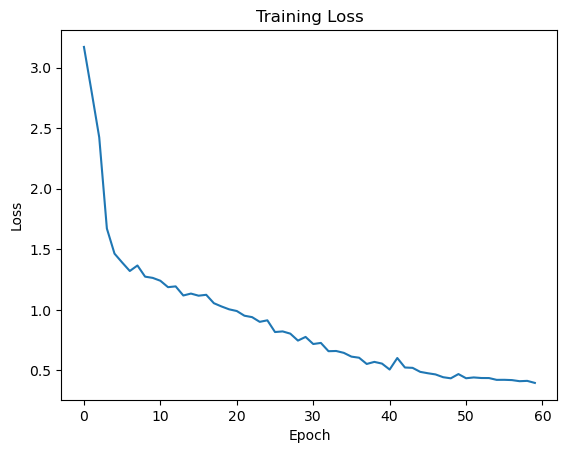

In [32]:
# plot the training loss
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluating the Model

Now we can evaluate the model on the test set. We first set the model to evaluation mode, then we iterate through the test set and make predictions. We then compare the predictions to the ground truth labels and compute the accuracy.


In [33]:
model.eval()

# test the accuracy per lead

correct_lead_1 = 0
correct_lead_2 = 0
correct_lead_3 = 0

with torch.no_grad():
    for data, target in test_dataloader:
        output_lead_1, output_lead_2, output_lead_3 = model(data)

        _, predicted_lead_1 = torch.max(output_lead_1.data, 1)
        _, predicted_lead_2 = torch.max(output_lead_2.data, 1)
        _, predicted_lead_3 = torch.max(output_lead_3.data, 1)

        _, target_lead_1 = torch.max(target[:, 0], 1)
        _, target_lead_2 = torch.max(target[:, 1], 1)
        _, target_lead_3 = torch.max(target[:, 2], 1)

        correct_lead_1 += (predicted_lead_1 == target_lead_1).sum().item()
        correct_lead_2 += (predicted_lead_2 == target_lead_2).sum().item()
        correct_lead_3 += (predicted_lead_3 == target_lead_3).sum().item()

# print the accuracy per lead in %
print(f"Accuracy Lead 1: {100 * correct_lead_1 / len(test_dataset):.2f}%")
print(f"Accuracy Lead 2: {100 * correct_lead_2 / len(test_dataset):.2f}%")
print(f"Accuracy Lead 3: {100 * correct_lead_3 / len(test_dataset):.2f}%")

Accuracy Lead 1: 70.52%
Accuracy Lead 2: 66.09%
Accuracy Lead 3: 61.18%


## Forecast with December 2023

We can now use the model to make a forecast. We will use the December 2023 data as input to the model and see what the model predicts for the next 3 months. You can download the data from this link



In [34]:
dec2023 = xr.open_dataset("data/ersst_anom_dec2023.nc").ssta
dec2023

<xarray.DataArray 'ssta' (lat: 41, lon: 86)> Size: 14kB
[3526 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 164B -40.0 -38.0 -36.0 -34.0 ... 34.0 36.0 38.0 40.0
  * lon      (lon) float32 344B 120.0 122.0 124.0 126.0 ... 286.0 288.0 290.0

In [35]:
# evaluate the model on the dec2023 data
model.eval()

pred_input = torch.from_numpy(
    dec2023.expand_dims("channel")
    .transpose("channel", "lat", "lon")
    .fillna(0)
    .data.copy()
)

with torch.no_grad():
    model_output = model(pred_input.unsqueeze(0))

In [36]:
print("0: Neutral, 1: El Nino, 2: La Nina")
print(f"Prediction for January 2024: {model_output[0].argmax()}")
print(f"Prediction for February 2024: {model_output[1].argmax()}")
print(f"Prediction for March 2024: {model_output[2].argmax()}")

0: Neutral, 1: El Nino, 2: La Nina
Prediction for January 2024: 0
Prediction for February 2024: 0
Prediction for March 2024: 0


## Improving the model 

If we want to improve the model, the first thing to ask ourselves is whether we are **underfitting** or **overfitting**. If we are not overfitting, then we are underfitting and we should increase the size of the model and train longer. If we are overfitting, then we should add regularization or get more training data.